## Introduction

The code below uses LangChain, OpenAI, neo4j, Pydantic, and yWorks to demonstrate simple NLP and examples of curating data prior to creating elements of a knowledge graph (KG).  

The first couple chapters of Frank Herbert's 1965 novel Dune will is the source text.

The approach used will:

1. Load the source text and split it into chunks.
2. Perform NER (named entity recognition) on the text splits (NER).
3. For the entities found, extract relationships between the entities.  
4. Persist the entities and relationships into a graph database.

Along the way, the data will be curated to increase the usefulness of the KG. As an LLM is used, its necessary to review the indeterminate extraction results produced. 

An open information extraction approach will be used for creating the KG. This means the knowledge graph will not have a pre-defined schema. The node labels and edges defined will by the LLM.

The purpose of this experiment is to demonstrate simple curation steps that can be taken when relying on a LLM to create a graph database. The steps take below could easily be implemented in a much more capable curation application.


In [1]:
import numpy as np
import pandas as pd
import tqdm

import warnings
warnings.filterwarnings("ignore")

from sentence_transformers import SentenceTransformer
from langchain.text_splitter import TokenTextSplitter
import Dune_Graph_RAG_Util as util

## NLP Processing

Below, NLP steps are performed on the corpus to extract entities and their relationships.

### Step 1: Split Text

The code below parses the corpus continued in the dune.txt by first getting each chapter and then splitting those chapters into chunks of approximately 500 tokens each.

In [2]:
dune_chapters = util.get_Dune_chapters()
print(f'# of Dune chapters {len(dune_chapters)}')
splitter = TokenTextSplitter(encoding_name='gpt2', chunk_size=500, chunk_overlap=50)
dune_splits = splitter.split_documents(dune_chapters[:5])
print(f'# of document chunks: {len(dune_splits)}')

# of Dune chapters 48
# of document chunks: 51


Lets take a look at the distribution of split word counts.

# Of Splits: 51
Max # words in a split: 485
Min # words: 60
Average # of words: 423.67
Total # of words: 21,607


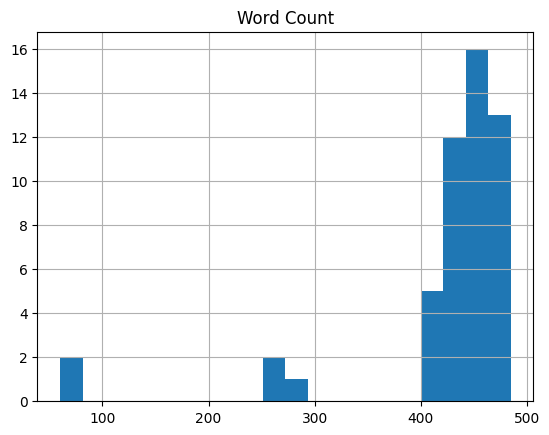

In [3]:
chpt_word_cnts = np.array([util.word_count(doc.page_content) for doc in dune_splits])
print(f'# Of Splits: {len(chpt_word_cnts)}')
print(f'Max # words in a split: {chpt_word_cnts.max():,}')
print(f'Min # words: {chpt_word_cnts.min():,}')
print(f'Average # of words: {chpt_word_cnts.mean():,.2f}')
print(f'Total # of words: {chpt_word_cnts.sum():,}')

cnt_df = pd.DataFrame(data={'Word Count': chpt_word_cnts})
hist = cnt_df.hist(bins=20)

### Step 2: Entity Extraction

The code below creates a list of entities by using an LLM to perform NER on the text splits. Prior to adding an entity to the list, a similarity score is calculated between the extracted entity and entities extracted in previous iterations. If the score exceeds a threshold of 0.70, the new entity is considered an alias of the existing entity. For example, two entities with the names "Duke Leto" and "Leto" are different aliases for the same entity. When an alias is found, it is added to a list in the existing entity that is used to track aliases.

The code below will only process the first three splits. 

In [4]:
NUMBER_OF_SPLITS_TO_PROCESS = 3
entity_extractor_llm = util.get_entity_llm()
embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Extract entities from text splits...
entities = []
for split, doc in enumerate(tqdm.tqdm(dune_splits[:NUMBER_OF_SPLITS_TO_PROCESS], desc ="Processing splits...")):
    new_entities = entity_extractor_llm.invoke({"context": doc}).entities
    util.initialize_entities(new_entities, embedder, split)
    entities = util.update_entity_list(new_entities, entities)

Processing splits...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.11s/it]


Below are the names, type, and descriptions of entities extracted from the splits.

In [5]:
entities.sort(key=lambda x: x.name)
print( '\n'.join([f'{idx+1}. ' + e.name + 
                  f' ({e.type})- # of references = {len(e.entity_alias)+1}' +
                  f', Aliases = {list(set([a.name for a in e.entity_alias]))}' for idx, e in enumerate(entities)]) )

1. Arrakis (Planet)- # of references = 3, Aliases = ['Arrakis']
2. Atreides (Family House)- # of references = 2, Aliases = ['House of Atreides']
3. Bene Gesserit (Organization)- # of references = 1, Aliases = []
4. CHOAM Company (Organization)- # of references = 1, Aliases = []
5. Castle Caladan (Family House)- # of references = 1, Aliases = []
6. Dr. Yueh (Person)- # of references = 1, Aliases = []
7. Duke Leto (Person)- # of references = 1, Aliases = []
8. Fremen (Organization)- # of references = 1, Aliases = []
9. Harkonnens (Family House)- # of references = 1, Aliases = []
10. Jessica (Person)- # of references = 2, Aliases = ['Jessica']
11. Kwisatz Haderach (Person)- # of references = 2, Aliases = ['Kwisatz Haderach']
12. Landsraad (Organization)- # of references = 1, Aliases = []
13. Muad'Dib (Person)- # of references = 1, Aliases = []
14. Paul (Person)- # of references = 3, Aliases = ['Paul']
15. Thufir Hawat (Person)- # of references = 2, Aliases = ['Hawat']
16. old woman (Perso

Lets curate the list a bit. The last entity is too generic to be useful so I removed it.

In [6]:
for _ in list(range(1)):
    print(entities.pop(-1).name)

old woman


Reviewing the rest of the list, there are some entities that could be merged. For instance Muad'Dib is an alias for Paul. This could be done with extra code, but I'll leave that for a future effort.

The code below combines an entity with the aliases found for it. For instance, along with entity names, a entity descriptions was extracted from the splits. The code below uses an LLM to summarize the descriptions found for an entity and its aliases into a single description.

In [7]:
entities = util.combine_similar_entities(entities)

Lets review the combined entities. Listed for each entity is its name, the splits they were referenced in, and its description.

In [8]:
print('\n'.join([f'{idx + 1 }. ' + e.name + f' ({",".join([str(k) for k in e.src_reference])})' 
                 + ': ' + e.description for idx, e in enumerate(entities)]))

1. Arrakis (0,1,2): Arrakis, also known as Dune, is the desert planet where the character Muad'Dib is located and is the main setting of the story.
2. Atreides (0): The Atreides family has a long history, spanning twenty-six generations, and is a powerful and influential family in the story. They reside in Castle Caladan.
3. Bene Gesserit (0): The Bene Gesserit is an organization to which the sisters belong, and they are known for taking delicate care of balances.
4. CHOAM Company (1): CHOAM Company is a powerful organization involved in mining the geriatric spice, melange.
5. Castle Caladan (2): Castle Caladan is a family house mentioned in the text as the world where Paul lives.
6. Dr. Yueh (2): Dr. Yueh is a character in the text who is mentioned as Paul's teacher.
7. Duke Leto (1): Duke Leto is the ruler of House Atreides.
8. Fremen (2): Fremen is an organization of people living on Arrakis without caid or bashar to command them.
9. Harkonnens (1): The Harkonnens are mortal enemies

### Step 3: Create Graph Nodes

Below, the entities extracted from the splits are used to create nodes in a neo4j graph database. Nodes for entity aliases are created with a "also known as" relationship to the main entity created.  

In [9]:
%%time
util.create_nodes(entities)

CPU times: total: 46.9 ms
Wall time: 35.6 s


Lets visualize the current state of the graph using ywork's graphing widget. Unfortunately, the interactive widget only works when the notebook code is run. Therefore, below the code is a screenshot of the widget.

In [10]:
util.showGraph('MATCH (n) OPTIONAL MATCH (n)-[r]->() RETURN n, r LIMIT 100')

GraphWidget(layout=Layout(height='670px', width='100%'))

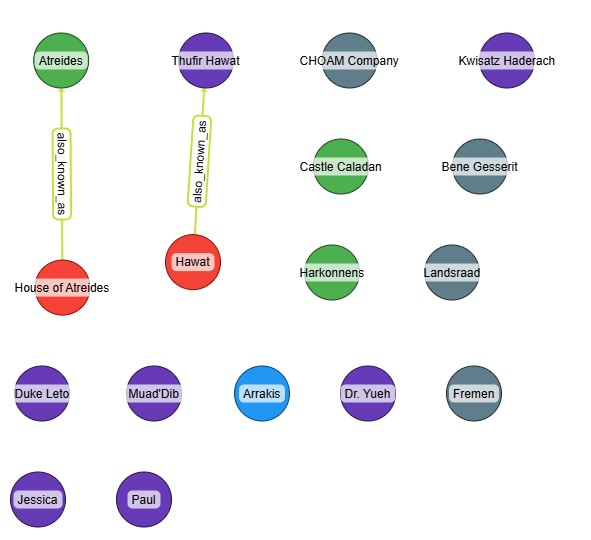

In [2]:
from IPython.display import Image
Image(filename='Dune_Graph_Rag_graph1.jpg')

### Step 4: Extract Entity Relationships

Below are two functions that:
* Extracts relationships between entities from the text splits.
* Persist the relationships found into the graph database.

In [11]:
def get_relationships(split: int):
    relationship_llm = util.get_relationship_llm()
    stmt = f""" 
    MATCH (n) WHERE n.chapters CONTAINS '[{split}]' 
    RETURN ID(n) as id, n.name as name, coalesce(n.description, '') as description, coalesce(labels(n)[0],'') as type
    """
    split_entities = [util.AnEntity(**dict(_)) for _ in util.execute_query(stmt)]
    split_relationships = []
    if len(split_entities) > 0:
        split_relationships = relationship_llm.invoke(
            {'context': dune_splits[split], 'entities': '\n'.join([entity.name for entity in split_entities])}
            )
    return split_entities, split_relationships

def write_relationshps(relationships:list, split_index: int): 
    parse_failures = []
    cyper_failures = []
    for r in relationships:
        stmt = None
        try:
            parts = r.split(':')
            if parts[0].strip() != parts [2].strip(): 
                stmt = (f'MERGE (p1 {{ name: "{parts[0].strip().replace('"','')}" }})'
                        f' ON CREATE SET p1.chapters = "[{split_index}]"'
                        f' ON MATCH  SET p1.chapters = CASE WHEN p1.chapters CONTAINS "[{split_index}]" THEN p1.chapters ELSE coalesce(p1.chapters, "") + "[{split_index}]" END ' 
                        f'MERGE (p2 {{ name: "{parts[2].strip().replace('"','')}" }}) '
                        f' ON CREATE SET p2.chapters = "[{split_index}]"'
                        f' ON MATCH  SET p2.chapters = CASE WHEN p2.chapters CONTAINS "[{split_index}]" THEN p2.chapters ELSE coalesce(p2.chapters, "") + "[{split_index}]" END '                         
                        f'MERGE (p1)-[r:{parts[1].strip().replace(' ', '_')}]->(p2);')
        except Exception as e:
            parse_failures.append(r)
        if stmt is not None:
            try:
                util.execute_write(stmt)
            except Exception as e:
                cyper_failures.append(stmt)
    if len(parse_failures):
        print(f'Parse errors occured:\n{parse_failures}') 
    if len(cyper_failures):
        print(f'Cypher errors occured:\n{cyper_failures}')

Below relationships are extracted from the text splits. To curate the relationships found by the LLM, I've made the processing interactive in that users can select which relationships to ignore when adding edges to the graph database. 

In [12]:
for split, _ in enumerate(tqdm.tqdm(dune_splits[:NUMBER_OF_SPLITS_TO_PROCESS], desc ="Processing splits...")):
    split_entities, split_relationships = get_relationships(split)
    split_relationships = split_relationships.split('\n')
    print([e.name for e in split_entities])
    print( '\n'.join( [f'{split}. {r}' for split, r in enumerate(split_relationships)] ) )
    print('-----')
    idxs = input('Enter space delimited indicies of relationships to ignore:')
    try: exclude_idxs = list(map(int, idxs.strip().split(" ")))
    except: exclude_idxs = []
    exclude_idxs = [idx for idx in exclude_idxs if idx < len(split_relationships)]
    filtered_list = [val for idx, val in enumerate(split_relationships) if idx not in exclude_idxs]
    print(filtered_list)
    print('Adding relationships to neo4j graph...')
    write_relationshps(filtered_list, split)
print('Done.')

Processing splits...:   0%|                                                                                               | 0/3 [00:00<?, ?it/s]

['Arrakis', 'Atreides', 'House of Atreides', 'Bene Gesserit', 'Jessica', 'Kwisatz Haderach', "Muad'Dib", 'Paul']
0. Arrakis:LOCATED_ON:planet
1. Atreides:RELATED_TO:House of Atreides
2. Bene Gesserit:AFFILIATED_WITH:Jessica
3. Jessica:MOTHER_OF:Paul
4. Kwisatz Haderach:ALSO_KNOWN_AS:Muad'Dib
5. Muad'Dib:IDENTIFIED_AS:Paul
-----


Enter space delimited indicies of relationships to ignore: 0


['Atreides:RELATED_TO:House of Atreides', 'Bene Gesserit:AFFILIATED_WITH:Jessica', 'Jessica:MOTHER_OF:Paul', "Kwisatz Haderach:ALSO_KNOWN_AS:Muad'Dib", "Muad'Dib:IDENTIFIED_AS:Paul"]
Adding relationships to neo4j graph...


Processing splits...:  33%|█████████████████████████████                                                          | 1/3 [00:49<01:38, 49.30s/it]

['Arrakis', 'CHOAM Company', 'Duke Leto', 'Harkonnens', 'Jessica', 'Kwisatz Haderach', 'Landsraad', 'Paul', 'Thufir Hawat', 'Hawat']
0. Arrakis:MINED_BY:CHOAM Company
1. Duke Leto:REPLACING:Harkonnens
2. Jessica:RELATION_TO:Paul
3. Kwisatz Haderach:IDENTITY_OF:Paul
4. Landsraad:AFFILIATED_WITH:Duke Leto
5. Paul:SON_OF:Duke Leto
6. Thufir Hawat:SERVANT_OF:Duke Leto
7. Hawat:MENTOR_OF:Paul
-----


Enter space delimited indicies of relationships to ignore: 


['Arrakis:MINED_BY:CHOAM Company', 'Duke Leto:REPLACING:Harkonnens', 'Jessica:RELATION_TO:Paul', 'Kwisatz Haderach:IDENTITY_OF:Paul', 'Landsraad:AFFILIATED_WITH:Duke Leto', 'Paul:SON_OF:Duke Leto', 'Thufir Hawat:SERVANT_OF:Duke Leto', 'Hawat:MENTOR_OF:Paul']
Adding relationships to neo4j graph...


Processing splits...:  67%|██████████████████████████████████████████████████████████                             | 2/3 [01:29<00:44, 44.15s/it]

['Arrakis', 'Castle Caladan', 'Dr. Yueh', 'Fremen', 'Paul']
0. Arrakis:LOCATED_ON:Desert Planet
1. Castle Caladan:LOCATED_ON:Arrakis
2. Dr. Yueh:TEACHER_OF:Paul
3. Fremen:INHABITANT_OF:Arrakis
4. Paul:RESIDENT_OF:Castle Caladan
-----


Enter space delimited indicies of relationships to ignore: 


['Arrakis:LOCATED_ON:Desert Planet', 'Castle Caladan:LOCATED_ON:Arrakis', 'Dr. Yueh:TEACHER_OF:Paul', 'Fremen:INHABITANT_OF:Arrakis', 'Paul:RESIDENT_OF:Castle Caladan']
Adding relationships to neo4j graph...


Processing splits...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:03<00:00, 41.28s/it]

Done.


### Step 5: Visualize Graph 

A visualization of entities their relationships created in the neo4j graph is below.

In [13]:
util.showGraph()

GraphWidget(layout=Layout(height='680px', width='100%'))

Again, below is screenshot of the interactive widget.

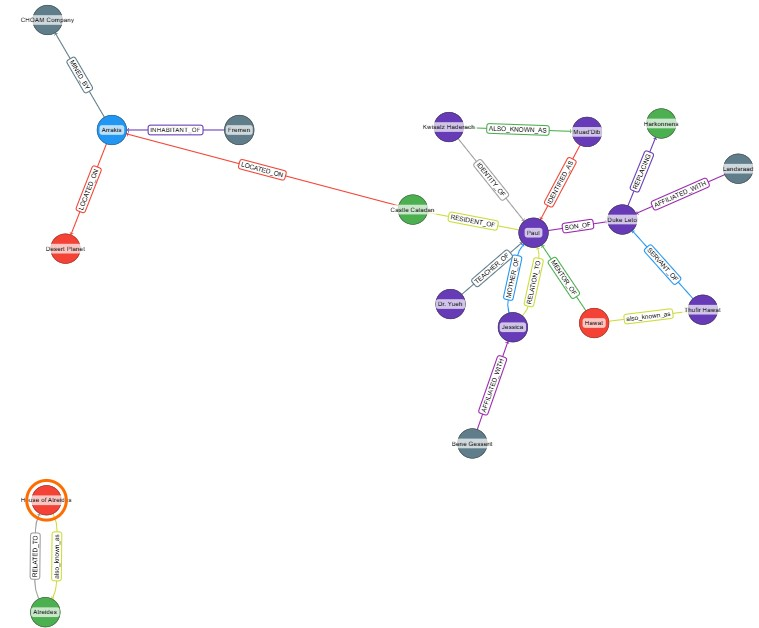

In [17]:
Image(filename='Dune_Graph_Rag_graph2.jpg')

This looks pretty good but some important relationships are missing or incorrect. Lets curate the graph a bit more using the graph manipulation statements below.

In [14]:
util.execute_write("MATCH (e1:Person {name: 'Paul' }) MATCH (e2 {name: 'Atreides' }) MERGE (e1)-[r:MEMBER_OF]->(e2)")
util.execute_write("MATCH (e1 {name: 'House of Atreides' }) MERGE (e2:Planet {name: 'Caladan' }) MERGE (e1)-[r:LOCATED_ON]->(e2)")
util.execute_write("MATCH (e1 {name: 'Castle Caladan' }) MATCH (e2:Planet {name: 'Arrakis' }) MATCH (e1)-[r:LOCATED_ON]->(e2) DELETE r")
util.execute_write("MATCH (e1:Person {name: 'Paul' }) MATCH (e2:Planet {name: 'Arrakis' }) MERGE (e1)-[r:MOVED_TO]->(e2)")
util.execute_write("MATCH (e1:Person {name: 'Paul' }) MATCH (e2:Planet {name: 'Caladan' }) MERGE (e1)-[r:BORN_ON]->(e2)")

Now lets view the KG again.

In [15]:
util.showGraph()

GraphWidget(layout=Layout(height='680px', width='100%'))

Screenshot below.

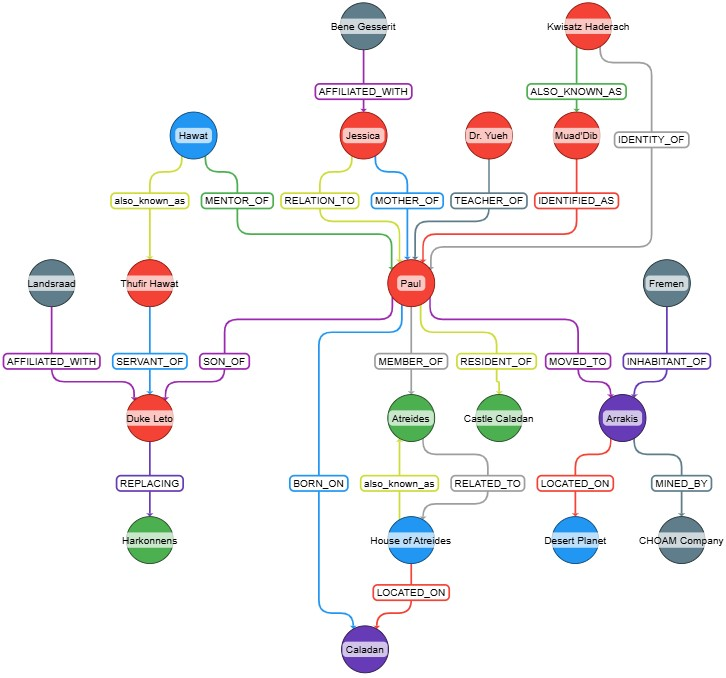

In [3]:
Image(filename='Dune_Graph_Rag_graph3.jpg')

The accuracy of the graph has been enhanced by the updates.  

## Conclusion



The indeterminate nature of LLMs necessitate the need for data curation to ensure accuracy. The experiments above are examples of simple curation steps that can be taken when creating a KG using LLMs. 


